# Import

In [1]:
import os
import itertools
import numpy as np
import tensorflow as tf
%tensorflow_version 1.x
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix

TensorFlow is already loaded. Please restart the runtime to change versions.


# Functions

In [2]:
class MyPlot():
    def __init__(self, nrows, ncols, figsize):
        self.fig, self.axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        
def my_histogram(ax, data, color, title=None, rwidth=None, log=True, bins=25, align='mid', density=None):
    ax.hist(data, color=color, log=log, bins=bins, edgecolor='black', linewidth=1.2, rwidth=rwidth, align=align, density=density);
    ax.set_title(title);

def plot_random_images(images, examples=16, fig_suptitle=None, figsize=(8,8), fpath=None):

    imgs_index = np.random.choice(np.arange(len(images)), examples, replace=False)

    plot = MyPlot(int(examples/np.sqrt(examples)), int(examples/np.sqrt(examples)), figsize=figsize)
    plot.axes = plot.axes.ravel()

    image_shape = images[0].shape

    for idx, _ in enumerate(plot.axes):
        
        X = images[imgs_index[idx]]
        
        if len(image_shape) == 2:
            
            plot.axes[idx].imshow(X=X,cmap="gray")
        
        else:
            
            plot.axes[idx].imshow(X=X)
        
        plot.axes[idx].axis('off')
    
    plot.fig.suptitle(fig_suptitle, fontsize=16)
    
    if fpath:
        plot.fig.savefig(fpath)        

def compute_confusion_matrix(y_true, y_false):
    cm = confusion_matrix(y_true, y_false)
    return cm

"""
This function prints and plots the confusion matrix.
Normalization can be applied by setting `normalize=True`.
"""
def plot_confusion_matrix(cm, classes, normalize=True, figsize=(7, 7), title='Confusion matrix', cmap=plt.cm.Greys):

    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    else:
    
        print('Confusion matrix without normalization')
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", fontsize=20, color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)


"""Convert an iterable of indices to one-hot encoded labels."""
def indices_to_one_hot(data, nb_classes):
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

def process_image_label(image, label):
    # Load the raw data from the file as a string
    image = resize_image(image)
    one_hot = label == CLASSES
    return image, one_hot

def resize_image(image):
    # Convert the compressed string to a 3D uint8 tensor
    tf.image.resize(image, [HEIGHT, WIDTH])
    return image

def normalize_image(image, label):
    return tf.cast(image, tf.float32) / 255., label

def configure_for_performance(ds, buffer_size, batch_size):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Load biological dataset

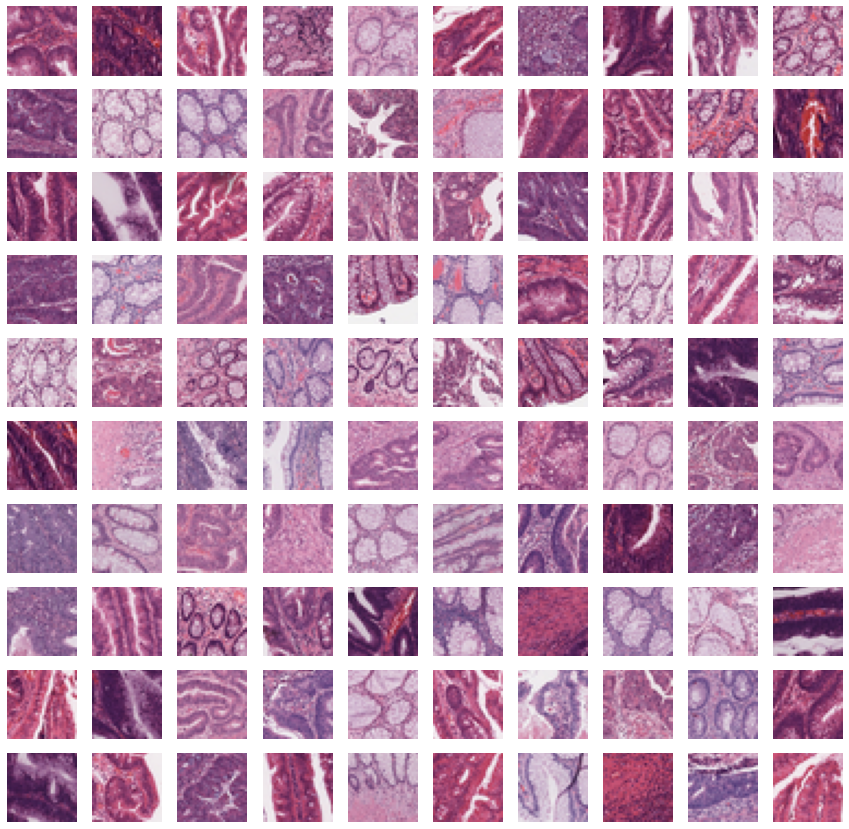

In [3]:
import requests, zipfile, io
r = requests.get("https://github.com/FrPo/crc_3_classi_64x64/blob/master/crc_3_classi.zip?raw=true") 

zip_file = zipfile.ZipFile(io.BytesIO(r.content))
zip_file.extractall()

X_train = np.load("/content/train_X.npy")
Y_train = np.load("/content/train_Y.npy")

X_test = np.load("/content/test_X.npy")
Y_test = np.load("/content/test_Y.npy")

plot_random_images(X_train, 100, figsize=(15, 15))

# TODO Training from scratch

In [19]:
VAL_SPLIT = 0.2
HEIGHT = 32
WIDTH = 32
BATCH_SIZE = 32
EPOCHS = 20
AUTOTUNE = tf.data.experimental.AUTOTUNE
CLASSES = sorted(list(set(Y_train))) #  AC:1 ; AD:2; H:3
CLASSES.sort()

# Implement VGG16 model training from scratch
# Remember to do zero-center normalization channel wise
# mean_image shape must be (3,), thus one mean value for each color channel

full_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

# Get number of images
image_count = tf.data.experimental.cardinality(full_ds).numpy()
print("Found {} images for training".format(image_count))

# Split into train and val ds
val_size = int(image_count * VAL_SPLIT)

train_ds = full_ds.skip(val_size)
val_ds   = full_ds.take(val_size)

# Map train ds
train_ds = train_ds.map(process_image_label, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(normalize_image)
train_ds = configure_for_performance(train_ds, buffer_size=100, batch_size=BATCH_SIZE)

# Map val ds
val_ds = val_ds.map(process_image_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(normalize_image)
val_ds = configure_for_performance(val_ds, buffer_size=100, batch_size=BATCH_SIZE)

vgg16 = tf.keras.applications.vgg16.VGG16(weights=None, include_top=False, input_shape=(HEIGHT, WIDTH, 3))

x = tf.keras.layers.GlobalAveragePooling2D()(vgg16.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(len(CLASSES), activation='softmax')(x)

for layer in vgg16.layers[:5]:
    layer.trainable = True
for layer in vgg16.layers[5:]:
    layer.trainable = True

model = tf.keras.Model(inputs=vgg16.input, outputs=predictions)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy']
)

# Create a TensorBoard callback
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs, histogram_freq = 1, profile_batch = '20, 30')

model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks = [tboard_callback])
print("Done")

Found 9000 images for training
Epoch 1/20
225/225 [==============================] - 22s 99ms/step - loss: 0.8124 - accuracy: 0.9347 - val_loss: 24.4582 - val_accuracy: 0.0000e+00
Epoch 2/20
225/225 [==============================] - 21s 91ms/step - loss: 0.9489 - accuracy: 0.8894 - val_loss: 29.3896 - val_accuracy: 0.0000e+00
Epoch 3/20
225/225 [==============================] - 21s 91ms/step - loss: 1.2818 - accuracy: 0.8031 - val_loss: 239.2436 - val_accuracy: 0.0000e+00
Epoch 4/20
225/225 [==============================] - 20s 91ms/step - loss: 2.4759 - accuracy: 0.8561 - val_loss: 13.0689 - val_accuracy: 0.0000e+00
Epoch 5/20
225/225 [==============================] - 20s 91ms/step - loss: 0.8472 - accuracy: 0.8072 - val_loss: 12.3311 - val_accuracy: 0.0000e+00
Epoch 6/20
225/225 [==============================] - 20s 90ms/step - loss: 0.7386 - accuracy: 0.7946 - val_loss: 7.4288 - val_accuracy: 0.0000e+00
Epoch 7/20
225/225 [==============================] - 21s 91ms/step - loss:

KeyboardInterrupt: ignored

# Features extraction

## TODO Load pretrained model

In [5]:
# Load a VGG16 pretrained model and print its summary

vgg16 = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, 3))

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

## TODO Features extraction

In [ ]:
EPOCHS = 2

model = tf.keras.Model(inputs=vgg16.input, outputs=vgg16.layers[5].output)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy']
)

# Create a TensorBoard callback
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '20, 30')

model.fit(train_ds,
          epochs=EPOCHS,
          validation_data=val_ds,
          callbacks = [tboard_callback])
print("Done")

Epoch 1/2


ValueError: ignored

## Features reshape
The idea is to flat a features array (if its dimension >=2) to train the downstream SVM (in order to avoid: ValueError: Found array with dim 4. Estimator expected <= 2)

In [ ]:
# Print and extract features shape
shape = [...]
print(shape)
# Get shapes of the flatten array (moltiplication of the all previous dimensions)
new_shape = [...]
features_train = np.reshape([...], [...])
# Same for test
shape = [...]
print(shape)
new_shape = [...]
features_test = np.reshape([...])

## TODO SVM classifier
(See https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [ ]:
[...] # Implement SVM classifier trained on features from CNN

# TODO Fine tuning

In [ ]:
base_model = [...] # Get a base model via Keras APIs

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Equip the model with:
# - GlobalAveragePooling2D layer
# - Dense layer
# - Prediction layer with softmax

# Decide a layer from with freezw the model

# Compile the model setting all the parameters
model.compile() 

mean_image = np.mean(X_train, axis=(0, 1, 2))
X_train_norm = (X_train - mean_image) / 255

model.fit() [...] # Implement model fit

X_test_norm = (X_test - mean_image) / 255

predictions = model.predict(X_test_norm)

cm = confusion_matrix(Y_test, np.argmax(predictions, axis=1))
plot_confusion_matrix(cm, ["AC", "AD", "H"], normalize=True, figsize=(4, 4))